In [174]:
%matplotlib inline

In [175]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [176]:
print(torch.__version__)

1.12.1+cu113


In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## prepare dataset

In [178]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


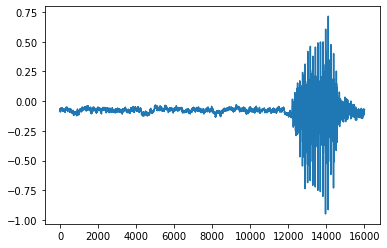

In [179]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

### Labels

In [180]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
print(labels)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [181]:
# sequence length
new_sample_rate = 300
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

### MFCC example

torch.Size([1, 40, 101])


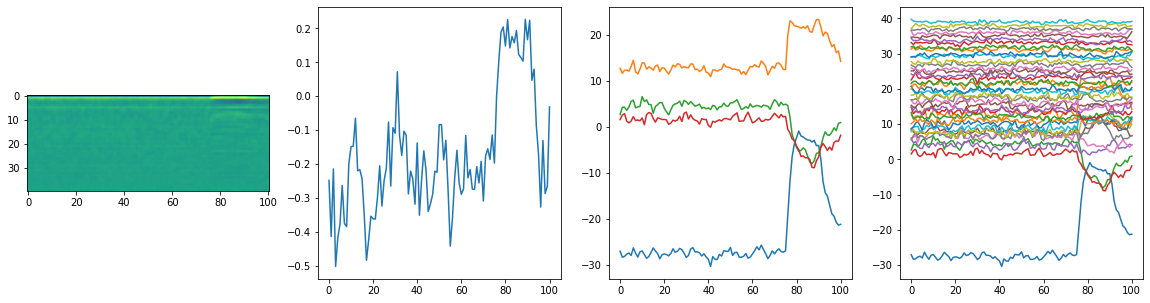

In [182]:
# MFCC:
transform = torchaudio.transforms.MFCC(sample_rate= 16000, n_mfcc = 40, dct_type = 2, norm='ortho', log_mels= True, melkwargs = {"n_mels":40,"n_fft": 480,"hop_length":160,"f_min":40,"f_max":8000})
# transform = torchaudio.transforms.MFCC(sample_rate= 16000, n_mfcc = 40, dct_type = 2, norm=None, log_mels= False, melkwargs = {"n_mels":40,"n_fft": 2048,"hop_length":512,"f_min":40,"f_max":8000})
transformed = transform(waveform)
print(transformed.shape)
plt.figure(figsize = (20,5))
plt.subplot(141)
plt.imshow(transformed.detach().numpy()[0,:,:])
plt.subplot(142)
plt.plot(transformed.detach().numpy()[0,:,:].mean(0))
plt.subplot(143)
for i in range(4):
    plt.plot(transformed.detach().numpy()[0,i,:]+i)
plt.subplot(144)
for i in range(40):
    plt.plot(transformed.detach().numpy()[0,i,:]+i)


In [183]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


### formate the dataset

In [184]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [185]:
for batch in train_loader:
    x,y = batch
    x = transform(x).permute(0,1,3,2)
    print(x.shape,y.shape)
    break

torch.Size([256, 1, 101, 40]) torch.Size([256])


In [186]:
in_dim = x.shape[1]*x.shape[-1]-4
T = x.shape[2]
n_classes = 35

Define the Network
------------------

<!-- For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms. -->




In [187]:
"""
Liquid time constant snn
"""
import os
import shutil
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.nn import init
from torch.autograd import Variable
import math
def create_exp_dir(path, scripts_to_save=None):
    if not os.path.exists(path):
        os.mkdir(path)

    print('Experiment dir : {}'.format(path))
    if scripts_to_save is not None:
        os.mkdir(os.path.join(path, 'scripts'))
        for script in scripts_to_save:
            dst_file = os.path.join(path, 'scripts', os.path.basename(script))
            shutil.copyfile(script, dst_file)
            

def model_save(fn, model, criterion, optimizer):
    with open(fn, 'wb') as f:
        torch.save([model, criterion, optimizer], f)

def model_load(fn):
    with open(fn, 'rb') as f:
        model, criterion, optimizer = torch.load(f)
    return model, criterion, optimizer

def save_checkpoint(state, is_best, prefix, filename='_rec2_bias_checkpoint.pth.tar'):
    print('saving at ', prefix+filename)
    torch.save(state, prefix+filename)
    if is_best:
        shutil.copyfile(prefix+filename, prefix+ '_rec2_bias_model_best.pth.tar')


def count_parameters(model):
    return sum(p.numel() for p in model.network.parameters() if p.requires_grad)

###############################################################################################
###############################    Define SNN layer   #########################################
###############################################################################################

b_j0 = .1  # neural threshold baseline
R_m = 3  # membrane resistance
dt = 1  
gamma = .5  # gradient scale
lens = 0.5

def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        # temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        # temp =  gaussian(input, mu=0., sigma=lens)
        return grad_input * temp.float() * gamma
        # return grad_input


act_fun_adp = ActFun_adp.apply

def mem_update_adp(inputs, mem, spike, tau_adp,tau_m, b, dt=1, isAdapt=1):
    alpha = tau_m # exp(-dt/tau) = sigmoid(x)
    
    ro = tau_adp

    if isAdapt:
        beta = 1.8
    else:
        beta = 0.

    b = ro * b + (1 - ro) * spike
    B = b_j0 + beta * b
    


    d_mem = -mem + inputs
    mem = mem + d_mem*alpha
    inputs_ = mem - B

    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    mem = (1-spike)*mem

    return mem, spike, B, b


def output_Neuron(inputs, mem, tau_m, dt=1):
    """
    The read out neuron is leaky integrator without spike
    """
    d_mem = -mem  +  inputs
    mem = mem+d_mem*tau_m
    return mem
###############################################################################################
###########################Liquid time-constant ####################################
###############################################################################################
class SNN_rec_cell(nn.Module): # layer
    def __init__(self, input_size, hidden_size,is_rec = True,is_LTC=True):
        super(SNN_rec_cell, self).__init__()
    
        
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.is_rec = is_rec
        self.is_LTC = is_LTC

        if is_rec:
            self.layer1_x = nn.Linear(input_size+hidden_size, hidden_size)
        else:
            self.layer1_x = nn.Linear(input_size, hidden_size)
        
        # time-constant definiation and initilization 
        if is_LTC:
            self.layer1_tauAdp = nn.Linear(2*hidden_size, hidden_size) # for each neuron's tau, all N neuorns, 2  
            self.layer1_tauM = nn.Linear(2*hidden_size, hidden_size)
            nn.init.xavier_uniform_(self.layer1_tauAdp.weight)
            nn.init.xavier_uniform_(self.layer1_tauM.weight)
        else:
            self.tau_adp = nn.Parameter(torch.Tensor(hidden_size))
            self.tau_m =nn.Parameter(torch.Tensor(hidden_size))
            nn.init.normal_(self.tau_adp, 4.6,.1)
            nn.init.normal_(self.tau_m, 3.,.1)
        self.act1 = nn.Sigmoid()#[0,1],
        self.act2 = nn.Sigmoid()

        nn.init.xavier_uniform_(self.layer1_x.weight)
        

    def forward(self, x_t, mem_t,spk_t,b_t):  
        # input calcualtion  
        if self.is_rec:
            dense_x = self.layer1_x(torch.cat((x_t,spk_t),dim=-1))
        else:
            dense_x = self.layer1_x(x_t)

        # time-constant calculation
        if self.is_LTC:
            tauM1 = self.act1(self.layer1_tauM(torch.cat((dense_x,mem_t),dim=-1))) # add resrictions 
            tauAdp1 = self.act1(self.layer1_tauAdp(torch.cat((dense_x,b_t),dim=-1)))
        else:
            tauM1 = self.act1(self.tau_m)
            tauAdp1 = self.act2(self.tau_adp)
        
        # states updates
        mem_1,spk_1,_,b_1 = mem_update_adp(dense_x, mem=mem_t,spike=spk_t,
                                        tau_adp=tauAdp1,tau_m=tauM1,b =b_t)

        return mem_1,spk_1,b_1

    def compute_output_size(self):
        return [self.hidden_size]

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size,output_size,is_LTC=True):
        super(SNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size 
        self.output_size = output_size
        
        self.rnn_name = 'SNN: is_LTC-'+str(is_LTC)

        self.snn_a = SNN_rec_cell(input_size,hidden_size,True,is_LTC)
 

        self.snn3 = SNN_rec_cell(hidden_size,hidden_size,True,is_LTC)
        

        self.layer3_x = nn.Linear(hidden_size,output_size,bias=True)
        self.layer3_tauM = nn.Linear(output_size*2,output_size)
        self.tau_m_o = nn.Parameter(torch.Tensor(output_size))

        nn.init.constant_(self.tau_m_o, 20.)
        # nn.init.constant_(self.tau_m_o, 0.)
        nn.init.xavier_uniform_(self.layer3_x.weight)
        nn.init.zeros_(self.layer3_tauM.weight)
        self.act3 = nn.Sigmoid()
        self.relu = nn.ELU()

        self.dp1 = nn.Dropout(0.1)#.1
        self.dp2 = nn.Dropout(0.1)
        self.dp3 = nn.Dropout(0.1)
        self.fr = 0
        
    def forward(self, inputs, h):
        
        
        # outputs = []
        hiddens = []
 
        b,c,t,in_dim= inputs.shape

        for i in range(t):
            x_down = inputs[:,:,i,:].reshape(b,self.input_size).float()

            mem_1,spk_1,b_1 = self.snn_a(x_down, mem_t=h[0],spk_t=h[1],b_t = h[2])
            mem_2,spk_2,b_2 = self.snn3(spk_1, mem_t=h[3],spk_t=h[4],b_t = h[5])

            dense3_x = self.layer3_x(spk_2)
            # tauM2 = self.act3(self.layer3_tauM(torch.cat((dense3_x, h[-2]),dim=-1)))
            tauM2 = torch.exp(-1./(self.tau_m_o))
            mem_out = output_Neuron(dense3_x,mem=h[-2],tau_m = tauM2)

            out =mem_out
            self.fr = self.fr+ spk_1.detach().cpu().numpy().mean()/2.\
                + spk_2.detach().cpu().numpy().mean()/2.

            h = (mem_1,spk_1,b_1, 
                mem_2,spk_2,b_2, 
                mem_out,
                out)

            f_output = F.log_softmax(out, dim=1)
            hiddens.append(h)

        
        final_state = h
        return f_output, final_state, hiddens

class SeqModel(nn.Module):
    def __init__(self, ninp, nhid, nout,is_rec=True,is_LTC = False):

        super(SeqModel, self).__init__()
        self.nout = nout    # Should be the number of classes
        self.nhid = nhid
        self.is_rec = is_rec
        self.is_LTC= is_LTC

        self.network = SNN(input_size=ninp, hidden_size=nhid, output_size=nout)
        

    def forward(self, inputs, hidden):
      
        t = inputs.size()[2]
        # print(inputs.shape) 
        outputs = []
        
        f_output, hidden, hiddens= self.network.forward(inputs, hidden)
        outputs.append(f_output)
        return outputs, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters()).data
        return (weight.new(bsz,self.nhid).uniform_(),
                weight.new(bsz,self.nhid).zero_(),
                weight.new(bsz,self.nhid).fill_(b_j0),
                # layer 3
                weight.new(bsz,self.nhid).uniform_(),
                weight.new(bsz,self.nhid).zero_(),
                weight.new(bsz,self.nhid).fill_(b_j0),
                # layer out
                weight.new(bsz,self.nout).zero_(),
                # sum spike
                weight.new(bsz,self.nout).zero_(),
                )




## FPTT function:

In [188]:
# fptt parameters
alpha = .5 # 0.1
beta = .5 # how march spatial vs temporal
rho = 0.

In [189]:
def get_stats_named_params( model ):
    named_params = {}
    for name, param in model.named_parameters():
        sm, lm, dm = param.detach().clone(), 0.0*param.detach().clone(), 0.0*param.detach().clone()
        named_params[name] = (param, sm, lm, dm)
    return named_params

def post_optimizer_updates( named_params):
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        lm.data.add_( -alpha * (param - sm) )
        sm.data.mul_( (1.0-beta) )
        sm.data.add_( beta * param - (beta/alpha) * lm )

def get_regularizer_named_params( named_params,  _lambda=1.0 ):
    regularization = torch.zeros( [], device=device )
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        regularization += (rho-1.) * torch.sum( param * lm )
        r_p = _lambda * 0.5 * alpha * torch.sum( torch.square(param - sm) )
        regularization += r_p
        # print(name,r_p)
    return regularization 

def reset_named_params(named_params):
    for name in named_params:
        param, sm, lm, dm = named_params[name]
        param.data.copy_(sm.data)

## test function

In [190]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # for data, target in test_loader:
    for i ,(data, target) in enumerate(test_loader):
        data = transform(data).permute(0,1,3,2)
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 1,T,40)[:,:,:,4:]
        with torch.no_grad():
            model.eval()
            hidden = model.init_hidden(data.size(0))
        
            outputs, hidden= model(data, hidden) 
           
            output = outputs[-1]
            # output = torch.stack(outputs[-10:]).mean(dim=0)
            
            test_loss += F.nll_loss(output, target, reduction='sum').data.item()
            pred = output.data.max(1, keepdim=True)[1]
        
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        torch.cuda.empty_cache()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
           test_loss, correct, len(test_loader.dataset),
           100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)

## training function

In [191]:
# training parameters

K  = T # sequence length
omega = int(T/K)
clip = -1. # default 0.1
log_interval = 100
lr = 1e-3 # 
# sequence is long: lr should be smaller 
# shorter: lr can be  3e-3

In [192]:

def train(train_loader, epoch,n_classes, model, named_params,optimizer):
    global steps
    global estimate_class_distribution

    train_loss = 0
    total_clf_loss = 0
    total_regularizaton_loss = 0
    total_oracle_loss = 0
    model.train()


    for batch_idx, (data, target) in enumerate(train_loader):
        data = transform(data).permute(0,1,3,2)
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 1,T,40)[:,:,:,4:]

       
        B = target.size()[0]
        

        for p in range(K):
            
            input_x  = data[:,:,p:(p+1)].detach().reshape(B,in_dim).float()
            if p>1:
                input_pre = data[:,:,(p-1):p].reshape(B,in_dim).float()
                mu_x = torch.abs(input_x + input_pre)/2.
                std_abs = torch.abs(input_x - input_pre)
            else:
                mu_x = torch.zeros(B,in_dim).to(device)
                std_abs = torch.abs(input_x).to(device)

            # calculated mu*std
            snr = torch.tanh(4*std_abs.mean(-1)*mu_x.mean(-1))

            if p==0:
                h = model.init_hidden(data.size(0))

            else: 
                h = tuple(v.detach() for v in h)

            # print([p.shape for p in h])
            if p<K-1:
                if epoch < 10:
                    oracle_prob = 0*estimate_class_distribution[target, p] + (1.0/n_classes)
                else:
                    oracle_prob = estimate_class_distribution[target, p]
            else:
                oracle_prob = F.one_hot(target,n_classes).float() 

            
            o, h,hs = model.network.forward(data[:,:,p:(p+1)], h )

            prob_out = F.softmax(h[-1], dim=1)
            output = F.log_softmax(h[-1], dim=1) 
          
            if p<K-1:
                with torch.no_grad():
                    filled_class = [0]*n_classes
                    n_filled = 0
                    for j in range(B):
                        if n_filled==n_classes: break
                        y = target[j].item()
                        if filled_class[y] == 0 and (torch.argmax(prob_out[j]) != target[j]):
                            filled_class[y] = 1
                            estimate_class_distribution[y, p] = prob_out[j].detach()
                            n_filled += 1
                            
            
            optimizer.zero_grad()
            
            # clf_loss = (p+1)/(K)*F.nll_loss(output, target)
            clf_loss = snr*F.nll_loss(output, target,reduction='none')
            clf_loss = torch.mean(clf_loss)
    
            # oracle_loss = 1.0 *torch.mean( -oracle_prob.to(device) * output )
            oracle_loss = (1 - (p+1)/(K)) *torch.mean(torch.mean( -oracle_prob.to(device) * output,axis=1)*snr)
                
            regularizer = get_regularizer_named_params( named_params, _lambda=1.0 )      
            loss = clf_loss  + regularizer  + oracle_loss

            loss.backward()

            if clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                
                
            optimizer.step()
            post_optimizer_updates( named_params)
        
            train_loss += loss.item()
            total_clf_loss += clf_loss.item()
            total_regularizaton_loss += regularizer #.item()
            total_oracle_loss += oracle_loss.item()
        
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlr: {:.6f}\tLoss: {:.6f}\tOracle: \
                {:.6f}\tClf: {:.6f}\tReg: {:.6f}\tFr: {:.6f}'.format(
                   epoch, batch_idx * batch_size, len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), lr, train_loss / log_interval, 
                   total_oracle_loss / log_interval, 
                   total_clf_loss / log_interval, total_regularizaton_loss / log_interval, model.network.fr/T/log_interval))
            # print(model.network.fr)
            train_loss = 0
            total_clf_loss = 0
            total_regularizaton_loss = 0
            total_oracle_loss = 0
            model.network.fr = 0


In [193]:
def get_xt(p, step, T, inputs):
    start = p*step
    end = (p+1)*step
    if (end >= T): end=T
        
    x = inputs[ :,:,start : end,: ]
    return x, start, end

In [194]:

def train_K(train_loader, epoch,n_classes, model, named_params,optimizer):
    global steps
    global estimate_class_distribution

    train_loss = 0
    total_clf_loss = 0
    total_regularizaton_loss = 0
    total_oracle_loss = 0
    model.train()


    for batch_idx, (data, target) in enumerate(train_loader):
        data = transform(data).permute(0,1,3,2)
        data, target = data.to(device), target.to(device)
        data = data.view(-1, 1,T,40)[:,:,:,4:]
      
       
        B = target.size()[0]
        
        
        for p in range(K):
            x, start, end = get_xt(p, omega, T, data)
            if p==0:
                h = model.init_hidden(data.size(0))
            else: 
                h = tuple(v.detach() for v in h)

            # print([p.shape for p in h])
            if p<K-1:
                if epoch < 10:
                    oracle_prob = 0*estimate_class_distribution[target, p] + (1.0/n_classes)
                else:
                    oracle_prob = estimate_class_distribution[target, p]
            else:
                oracle_prob = F.one_hot(target,n_classes).float() 

            
            
            o, h,hs = model.network.forward(x, h )

            prob_out = F.softmax(h[-1], dim=1)
            output = F.log_softmax(h[-1], dim=1) 
          
            if p<K-1:
                with torch.no_grad():
                    filled_class = [0]*n_classes
                    n_filled = 0
                    for j in range(B):
                        if n_filled==n_classes: break
                        y = target[j].item()
                        if filled_class[y] == 0 and (torch.argmax(prob_out[j]) != target[j]):
                            filled_class[y] = 1
                            estimate_class_distribution[y, p] = prob_out[j].detach()
                            n_filled += 1
                            
            
            optimizer.zero_grad()
            
            clf_loss = (p+1)/(K)*F.nll_loss(output, target)
            # clf_loss = snr*F.cross_entropy(output, target,reduction='none')
            # clf_loss = torch.mean(clf_loss)
    
            # oracle_loss = 1.0 *torch.mean( -oracle_prob.to(device) * output )
            oracle_loss = (1 - (p+1)/(K)) *torch.mean( -oracle_prob.to(device) * output)
                
            regularizer = get_regularizer_named_params( named_params, _lambda=1.0 )      
            loss = clf_loss  + regularizer  + oracle_loss

            loss.backward()

            if clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                
                
            optimizer.step()
            post_optimizer_updates( named_params)
        
            train_loss += loss.item()
            total_clf_loss += clf_loss.item()
            total_regularizaton_loss += regularizer #.item()
            total_oracle_loss += oracle_loss.item()
        
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlr: {:.6f}\tLoss: {:.6f}\tOracle: \
                {:.6f}\tClf: {:.6f}\tReg: {:.6f}\tFr: {:.6f}'.format(
                   epoch, batch_idx * batch_size, len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), lr, train_loss / log_interval, 
                   total_oracle_loss / log_interval, 
                   total_clf_loss / log_interval, total_regularizaton_loss / log_interval, model.network.fr/T/log_interval))
            # print(model.network.fr)
            train_loss = 0
            total_clf_loss = 0
            total_regularizaton_loss = 0
            total_oracle_loss = 0
            model.network.fr = 0


In [195]:
model = SeqModel(ninp=in_dim,
                    nhid=128,
                    nout=n_classes)
model.to(device)
total_params = count_parameters(model)

In [196]:
optimizer = optim.Adam(model.parameters(), lr=lr)#, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.

In [197]:
test_loss, acc1 = test( model, test_loader )


Test set: Average loss: 3.5815, Accuracy: 279/11005 (3%)



In [ ]:
epochs = 30
named_params = get_stats_named_params( model )
prefix ='save name'
all_test_losses = []
best_acc1 = 20

estimate_class_distribution = torch.zeros(n_classes, T, n_classes, dtype=torch.float)
for epoch in range(epochs):
    train(train_loader, epoch,n_classes, model, named_params,optimizer)   

    reset_named_params(named_params)


    test_loss, acc1 = test( model, test_loader )


    scheduler.step()

        
    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)
        
    # save_checkpoint({
    #         'epoch': epoch + 1,
    #         'state_dict': model.state_dict(),
    #         #'oracle_state_dict': oracle.state_dict(),
    #         'best_acc1': best_acc1,
    #         'optimizer' : optimizer.state_dict(),
    #         #'oracle_optimizer' : oracle_optim.state_dict(),
    #     }, is_best, prefix=prefix)

    all_test_losses.append(test_loss)

test_loss, acc1 = test( model, test_loader )